In [375]:
import subprocess
import sys

from glob import glob
from io import StringIO
from pathlib import Path

import librosa
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.legend_handler import HandlerTuple
from tqdm import tqdm

IS_WINDOWS = sys.platform.startswith("win")

dataset_folder = "data/datasets"

## Exploratory data analysis

### Overview

We are interested in LID for the [North Germanic](https://en.wikipedia.org/wiki/North_Germanic_languages) language sub-family, which comprises Danish, Faroese, Icelandic, Norwegian, and Swedish.

We will use the following corpuses:
 * [Common Voice 17.0](https://commonvoice.mozilla.org/), a crowd-sourcing effort which gathers recordings of native speakers in 100+ languages reading sentences from their language's Wikipedia
 * [FLEURS-R](https://www.arxiv.org/abs/2408.06227), an updated version of [FLEURS](https://arxiv.org/abs/2205.12446) which contains recordings of native speakers in 100+ languages reading sentences extracted (and translated) from the English Wikipedia
 * A subset of the [RAVNURSSON Corpus](https://huggingface.co/datasets/carlosdanielhernandezmena/ravnursson_asr), an ASR corpus for Faroese

For this project, we will group Norwegian Bokmål and Norwegian Nynorsk together, although this is not [technically correct](https://en.wikipedia.org/wiki/Norwegian_language).

We have prepared several scripts to download and prepare the above-mentioned datasets in the ```scripts``` folder. We show here their structure

In [43]:
# sudo apt install tree
!tree $dataset_folder --filelimit 40

data/datasets
├── common_voice_17_0
│   ├── da
│   │   └── da
│   │       ├── audio
│   │       │   ├── dev  [2105 entries exceeds filelimit, not opening dir]
│   │       │   ├── test  [2531 entries exceeds filelimit, not opening dir]
│   │       │   └── train  [3484 entries exceeds filelimit, not opening dir]
│   │       ├── dev.tsv
│   │       ├── test.tsv
│   │       └── train.tsv
│   ├── is
│   │   └── is
│   │       ├── audio
│   │       │   ├── dev
│   │       │   ├── test
│   │       │   └── train
│   │       │       ├── common_voice_is_37051265.mp3
│   │       │       ├── common_voice_is_37051266.mp3
│   │       │       ├── common_voice_is_37051268.mp3
│   │       │       ├── common_voice_is_37051269.mp3
│   │       │       ├── common_voice_is_37051280.mp3
│   │       │       ├── common_voice_is_37051281.mp3
│   │       │       ├── common_voice_is_37051282.mp3
│   │       │       ├── common_voice_is_37051283.mp3
│   │       │       ├── common_voice_is_37051284.mp3
│   │       │

### Language codes

Each dataset uses, unfortunately, different codes to represent the languages. Using Glottolog, we have semi-manually reconstructed a table to show the different codes and languages available in each dataset.

In [137]:
codes = pd.read_csv("data/languages/nort3160.csv", index_col=0)

codes

,fleurs-r,common_voice_17_0,ravnursson,glottolog
language,,,,
Danish,da_dk,da,NaN,dani1285
Faroese,NaN,NaN,fo,faro1244
Icelandic,is_is,is,NaN,icel1247
Norwegian,nb_no,nn-NO,NaN,norw1258
Swedish,sv_se,sv-SE,NaN,swed1254


In [316]:
stacked_codes = codes.drop("glottolog", axis=1).stack().droplevel(1, axis=0)

language2code = stacked_codes.groupby(stacked_codes.index).apply(list).to_dict()

print(language2code)

code2language = (
    stacked_codes
    .reset_index()
    .set_index(0)
    .to_dict()["language"]
)

code2language

{'Danish': ['da_dk', 'da'], 'Faroese': ['fo'], 'Icelandic': ['is_is', 'is'], 'Norwegian': ['nb_no', 'nn-NO'], 'Swedish': ['sv_se', 'sv-SE']}


{'da_dk': 'Danish',
 'da': 'Danish',
 'fo': 'Faroese',
 'is_is': 'Icelandic',
 'is': 'Icelandic',
 'nb_no': 'Norwegian',
 'nn-NO': 'Norwegian',
 'sv_se': 'Swedish',
 'sv-SE': 'Swedish'}

### Data imbalance

* We see that there is large imbalance in the chosen corpus. For instance, Swedish contains ~20x more samples than Icelandic. Moreover, the dataset is not representative of the number of speakers for these languages [source](https://en.wikipedia.org/wiki/North_Germanic_languages#Demographics); Norwegian is clearly underrpresented, while Faroese is extremely overrepresented due to the addition of the Ravnursson dataset.

* However, most models that we will used have been pre-trained on [VoxLingua107](https://bark.phon.ioc.ee/voxlingua107/), a large speech corpus that contains 34 hours of Swedish, 164 hours of Norwegian (107 of Bokmaal and 57 of Nynorsk), 92 hours of Icelandic, 28 hours of Danish, and 67 hours of Faroese. This pre-training on a more balanced corpus may help mitigate the effects of the imbalance in our chosen corpus to some extent.

In [288]:
stats = {}

datasets = ["fleurs-r", "common_voice_17_0", "ravnursson"]

for dataset in datasets:
    for i, subset in enumerate(["train", "dev", "test"]):
        stats[f"{dataset}/{subset}"] = {}
        language_paths = glob(f"{dataset_folder}/{dataset}/*/*")
        for language_path in language_paths:
            stats[f"{dataset}/{subset}"][code2language[Path(language_path).stem]] = len(
                glob(f"{language_path}/audio/{subset}/*")
            )

stats_df = pd.DataFrame(stats).sort_index()

stats_df

,fleurs-r/train,fleurs-r/dev,fleurs-r/test,common_voice_17_0/train,common_voice_17_0/dev,common_voice_17_0/test,ravnursson/train,ravnursson/dev,ravnursson/test
Danish,2183.0,395.0,926.0,3484.0,2105.0,2531.0,NaN,NaN,NaN
Faroese,NaN,NaN,NaN,NaN,NaN,NaN,10000.0,3331.0,3002.0
Icelandic,924.0,36.0,47.0,14.0,0.0,0.0,NaN,NaN,NaN
Norwegian,2323.0,162.0,357.0,515.0,283.0,371.0,NaN,NaN,NaN
Swedish,2372.0,331.0,756.0,7744.0,5210.0,5260.0,NaN,NaN,NaN


In [290]:
stats_df.sum(1)

Danish       11624.0
Faroese      16333.0
Icelandic     1021.0
Norwegian     4011.0
Swedish      21673.0
dtype: float64

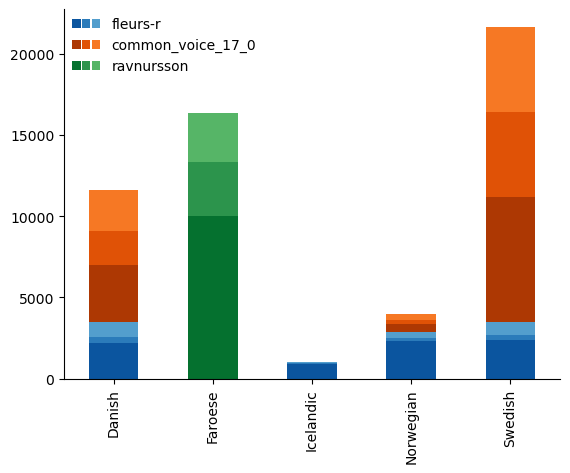

In [289]:
stats_df.plot.bar(
    stacked=True,
    color=[
        *sns.color_palette("Blues_r").as_hex()[:3],
        *sns.color_palette("Oranges_r").as_hex()[:3],
        *sns.color_palette("Greens_r").as_hex()[:3],
    ],
)

all_containers = []

colors = []

for container in plt.gca().containers:
    for c in container:
        c_color = c.get_facecolor()
        if not c_color in colors:
            all_containers.append(c)
            colors.append(c_color)

all_containers = tuple(all_containers)

handles, labels = plt.gca().get_legend_handles_labels()

plt.gca().legend(
    [all_containers[:3], all_containers[3:6], all_containers[6:]], datasets, handler_map={tuple: HandlerTuple(ndivide=None)}, borderpad=.1, frameon=False
)
sns.despine()
plt.show()

### Duplicates

As a speech corpus, our data does not have missing values per se, but we will check that files are not empty.

To examine duplicates, we will assume that the files have been correctly labelled, as they come from trusted and public sources which can be fact-checked (all published in Huggingface), and we do not have ourselves the expertise to fact-check that the labelling.

Thus, we will examine the possibility of within-language duplicates.



#### File sizes

A first easy step in examining duplicates is looking at file sizes, durations (and sample rates).

In [444]:
for language, codes in language2code.items():
    durations = []
    samplerates = []
    file_sizes = []
    files = []
    for code in codes:
        pattern = f"{dataset_folder}/*/{code}/{code}/audio/*/"

        try:
            ls = subprocess.run(
                f"ls -l {pattern}*.wav", capture_output=True, shell=not IS_WINDOWS, check=True
            )
        except subprocess.CalledProcessError:
            ls = subprocess.run(
                f"ls -l {pattern}*.mp3", capture_output=True, shell=not IS_WINDOWS, check=True
            )

        code_sizes = (
            pd.read_csv(
                StringIO(
                    ls.stdout.decode("utf-8").replace("   ", " ").replace("  ", " ")
                ),
                sep=" ",
                header=None,
                # on_bad_lines="warn",
            )
            .iloc[:, 4]
            .values
        )

        # sorted ensures the file order will be similar to the ls -l call
        all_code_audios = sorted(glob(f"{pattern}*.wav") + glob(f"{pattern}*.mp3"))

        for audio in tqdm(all_code_audios, desc=f"{language} ({code})"):
            durations.append(librosa.get_duration(path=audio))
            samplerates.append(librosa.get_samplerate(audio))

        file_sizes.extend(code_sizes)
        files.extend(all_code_audios)

    sizes_and_durations = pd.DataFrame(
        {
            "file": files,
            "filesize": file_sizes,
            "duration": durations,
            "samplerate": samplerates
        }
    )

    sizes_and_durations.to_csv(f"data/stats/sizes_and_durations_{language}.csv")

Danish (da_dk):   0%|          | 0/3501 [00:00<?, ?it/s]

Swedish (sv-SE): 100%|██████████| 18213/18213 [00:03<00:00, 5446.50it/s]


In [443]:
pd.DataFrame(sizes_and_durations["Danish"])

,file,filesize,duration,samplerate
0,data/datasets/fleurs-r/da_dk/da_dk/audio/dev/1...,616364,12.840000,24000
1,data/datasets/fleurs-r/da_dk/da_dk/audio/dev/1...,322604,6.720000,24000
2,data/datasets/fleurs-r/da_dk/da_dk/audio/dev/1...,347564,7.240000,24000
3,data/datasets/fleurs-r/da_dk/da_dk/audio/dev/1...,693164,14.440000,24000
4,data/datasets/fleurs-r/da_dk/da_dk/audio/dev/1...,433964,9.040000,24000
...,...,...,...,...
11615,data/datasets/common_voice_17_0/da/da/audio/tr...,19582,3.263656,32000
11616,data/datasets/common_voice_17_0/da/da/audio/tr...,21526,3.587656,32000
11617,data/datasets/common_voice_17_0/da/da/audio/tr...,16774,2.795656,32000
11618,data/datasets/common_voice_17_0/da/da/audio/tr...,18934,3.155656,32000
